Team Information:
Revanth Kurmeti - 1002068038  
Akhila Thota - 1002067862 
Jithin Krishna Kongara - 1002079491  
Meghana Katraju - 1002088571  
Sri Samrajya Vybhav Mallappa - 1002072400  

## Data Loading  
The data should be in below folder structure. Else you will get errors.

data  
    train2014  
       [training images]  
     val2014  
       [validation images]  
     MultipleChoice_mscoco_train2014_questions.json  
     mscoco_train2014_annotations.json  
     MultipleChoice_mscoco_val2014_questions.json  
     mscoco_val2014_annotations.json  

In [1]:
import json
from pathlib import Path
import re
import os

import numpy as np
import pandas as pd
from PIL import Image

ROOT_DIR = "./data"


IMG_DIR = f"{ROOT_DIR}/train2014"
VAL_IMG_DIR = f"{ROOT_DIR}/val2014"



QUESTIONS_FILE = ROOT_DIR + "/MultipleChoice_mscoco_{subset}2014_questions.json"
ANNOTATIONS_FILE = ROOT_DIR + "/mscoco_{subset}2014_annotations.json"

START_TOKEN = "<start>"
END_TOKEN = "<end>"

def read_image(image_path: Path, expand: bool = True) -> np.ndarray:
    with Image.open(image_path) as image:
        image = image.convert("RGB")
        image = np.asarray(image.resize((224, 224))) / 255.0
        if expand:
            image = np.expand_dims(image, axis=0)
    return image


def get_image_path(subset: str, image_id: int) -> str:
    IMAGE_DIR = IMG_DIR if subset == "train" else VAL_IMG_DIR
    return f"{IMAGE_DIR}/COCO_{subset}2014_{str(image_id).zfill(12)}.jpg"


def get_image_id(image_name: str) -> int:
    match = re.search(r"_(\d+)\.", image_name)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Invalid image name format: {image_name}")


def get_questions(question_file: str) -> dict:
    with open(question_file) as f:
        file = json.load(f)
        questions = file["questions"]
    return questions



def get_annotations(annotation_file: str) -> dict:
    with open(annotation_file) as f:
        file = json.load(f)
        annotations = file["annotations"]

    annotations = {i["question_id"]: i["multiple_choice_answer"] for i in annotations}
    return annotations


def load_data(subset: str = "train") -> pd.DataFrame:
    questions_file = QUESTIONS_FILE.format(subset=subset)
    annotation_file = ANNOTATIONS_FILE.format(subset=subset)
    IMAGE_DIR = IMG_DIR if subset == "train" else VAL_IMG_DIR
    annotations = get_annotations(annotation_file)
    questions = get_questions(questions_file)

    images_in_dir = set(get_image_id(i) for i in os.listdir(IMAGE_DIR))
    questions = [q for q in questions if q["image_id"] in images_in_dir]

    rows = []
    for q in questions:
        image_name = get_image_path(subset, q["image_id"])
        row = {
            "image_id": q["image_id"],
            "question": q["question"],
            "question_id": q["question_id"],
            "image": image_name,
        }
        answer = annotations.get(q["question_id"], "")
        words = answer.split(" ")
        seq = START_TOKEN

        for i, word in enumerate(words):
            row_copy = row.copy()
            row_copy["question"] = row_copy["question"] + f" {seq}"
            seq += f" {word}"
            row_copy["answer"] = word
            rows.append(row_copy)
        row["question"] = row["question"] + f" {seq} {END_TOKEN}"
        row["answer"] = answer
        rows.append(row)
    return pd.DataFrame(rows)

In [2]:
from sklearn.model_selection import train_test_split

# dataset = load_data("val")
# all_questions = dataset["question"].tolist()
# all_answers = dataset["answer"].tolist()
# train_df, test_df = train_test_split(dataset, test_size=0.1)

train_df = load_data("train")
test_df = load_data("val")
all_questions = train_df["question"].tolist()
all_answers = train_df["answer"].tolist()

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_length = 256
tokenizer = Tokenizer()
answer_tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_questions)
answer_tokenizer.fit_on_texts(all_answers)
answer_vocab_size = len(answer_tokenizer.word_index) + 1

### The Question Encoder - Using the pretrained 'glove-wiki-gigaword-100' word2vec model and an lstm layer

In [4]:
import numpy as np
import gensim.downloader as api

class QuestionEncoder:
    def __init__(
        self,
        max_sequence_length=100,
        embedding_dim=100,
        lstm_units=256,
        embedding_name="glove-wiki-gigaword-100",
    ):
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.tokenizer = tokenizer
        self.word_index = self.tokenizer.word_index
        self.embedding_matrix = None
        self.model = None
        self.load_embeddings(embedding_name)
        self.build_model()

    def load_embeddings(self, embedding_name):
        embeddings = api.load(embedding_name)
        num_words = len(self.tokenizer.word_index) + 1
        self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
        for word, i in self.tokenizer.word_index.items():
            if word in embeddings:
                self.embedding_matrix[i] = embeddings[word]

    def build_model(self):
        self.inputs = tf.keras.layers.Input(shape=(self.max_sequence_length,))
        x = tf.keras.layers.Embedding(
            len(self.tokenizer.word_index) + 1,
            self.embedding_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_sequence_length,
            trainable=False,
        )(self.inputs)
#         x = tf.keras.layers.LSTM(self.lstm_units, return_sequences=True)(x)
        x = tf.keras.layers.LSTM(self.lstm_units)(x)
        self.outputs = x
        self.model = tf.keras.Model(inputs=self.inputs, outputs=self.outputs)

    def encode(self, questions):
        padded_sequences = preprocess_text(questions)
        embeddings = self.model.predict(padded_sequences)
        return embeddings

    def decode(self, embeddings):
        sequences = self.model.predict(embeddings)
        questions = self.tokenizer.sequences_to_texts(sequences)
        return questions

### The Image Encoder  
Implemented using the VGG16 pretrained model without the top layer. The VGG16 network weights are frozen and a few fully connected layers added to the model.

In [5]:

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers


class ImageEncoder:
    def __init__(self):
        self.inputs = tf.keras.layers.Input(shape=(224, 224, 3))
        self.vgg16 = VGG16(weights="imagenet", include_top=False)
        for layer in self.vgg16.layers:
            layer.trainable = False
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(0.2)
        self.dense1 = layers.Dense(1024, activation="relu")
        self.dense2 = layers.Dense(512, activation="relu")
        self.dense3 = layers.Dense(256, activation="relu")
        self.build_model()

    def build_model(self):
        x = self.vgg16(self.inputs)
        x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dropout(x)
#         x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        self.outputs = x
        self.model = tf.keras.Model(inputs=self.inputs, outputs=self.outputs)

    def encode(self, images):
        return self.model.predict(images)

## The fusion mechanism
An attention layer is implemented using a dot product and softmax. The fused features are then passed to a fully connected layer and then softmaxed

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dot, Activation, Concatenate, Dense, Input, Dropout



class VQA:
    def __init__(self):
        self.question_encoder = QuestionEncoder(max_sequence_length)
        self.image_encoder = ImageEncoder()

        self.q_input = self.question_encoder.inputs
        self.q_output = self.question_encoder.outputs

        self.i_input = self.image_encoder.inputs
        self.i_output = self.image_encoder.outputs

        self.attention_dot = Dot(axes=[1,1], name="attention_dot")(
            [self.q_output, self.i_output]
        )
        self.attention_softmax = Dense(
            units=max_sequence_length, activation="softmax", name="attention_softmax"
        )(self.attention_dot)
        
        self.question_attention = Dot(axes=[1, 1], name="question_attention")(
            [self.attention_softmax, self.q_output]
        )
        
        x = Concatenate(axis=-1, name="combined_output")(
            [self.question_attention, self.i_output]
        )
        
        x = Dropout(0.2)(x)
        x = Dense(answer_vocab_size, activation="softmax", name="prediction")(x)
        
        self.model = tf.keras.Model(
            inputs=[self.q_input, self.i_input], outputs=x
        )
        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )

    def compile(self, optimizer, loss, metrics):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [7]:
def preprocess_text(questions):
    sequences = tokenizer.texts_to_sequences(questions)
    padded_sequences = pad_sequences(
        sequences, maxlen=max_sequence_length, padding="pre"
    )
    return tf.convert_to_tensor(padded_sequences, dtype=tf.int32)

def prepocess_answers(answers):
    arr = answer_tokenizer.texts_to_matrix(answers)
    return tf.convert_to_tensor(arr, dtype=tf.int32)

### Training the network

In [8]:
def data_generator(df, batch_size: int = 32):
    while True:
        batch = df.sample(batch_size)
        labels = prepocess_answers(batch["answer"].values)
        questions = preprocess_text(batch["question"].values)
        images = tf.convert_to_tensor(np.concatenate(batch["image"].map(read_image).values, axis=0), tf.float32)
        yield [questions, images], labels

In [9]:
vqa = VQA()
model = vqa.model

In [10]:
checkpoint_filepath = 'checkpoints/checkpoint'

if os.path.exists(checkpoint_filepath):
    try:
        model.load_weights(checkpoint_filepath)
    except Exception as e:
        print(e)

In [11]:
from tensorflow.keras import callbacks
import os

batch_size = 64
epochs = 3
steps_per_epoch = len(train_df) // batch_size
val_steps = len(test_df) // batch_size


model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
)

train_data = data_generator(train_df, batch_size)
val_data = data_generator(test_df, batch_size)

In [ ]:
DO_TRAIN = True
if DO_TRAIN:
    model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        callbacks=[model_checkpoint_callback]
    )

Epoch 1/3
  46/8189 [..............................] - ETA: 40:45:37 - loss: 6.5505 - categorical_accuracy: 0.2245

### Model Evaluation

In [17]:
val_acc = model.evaluate(val_data, steps=5)
print(f"Validation accuracy after {epochs} epochs: {val_acc}")

5/5 [==============================] - 95s 19s/step - loss: 9.5221 - categorical_accuracy: 0.0000e+00
Validation accuracy after 3 epochs: [9.522085189819336, 0.0]


In [18]:
index_to_word = {v: k for k, v in answer_tokenizer.word_index.items()}

def predict(question: str, image: str):
    question += f" {START_TOKEN}"
    word = ""
    answer = ""
    while (word != 'end'):
        pred = model.predict([preprocess_text([question]), read_image(image)], verbose=False)
        index = pred[0].argmax()
        next_word = index_to_word[index]
        if next_word == word:
            break
        word = next_word
        question += f" {word}"
        answer += f"{word} "
    return answer

In [19]:
import cv2

def get_attention_map(question, image_path):
    attention_model = tf.keras.Model(
        inputs=[vqa.q_input, vqa.i_input], outputs=vqa.attention_softmax
    )
    tokens = preprocess_text([question])
    image = read_image(image_path)
    attention_map = attention_model.predict([tokens, image], verbose=0)
    attention_map = attention_map.reshape(16, 16)
    attention_map = np.expand_dims(attention_map, axis=-1)
    # Resize the attention map to match the size of the input image
    attention_map = tf.image.resize(
        attention_map, [224, 224], method="bilinear"
    ).numpy()
    
    # Normalize the attention map values to be between 0 and 1
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Convert the attention map to a heatmap image
    heatmap = cv2.applyColorMap(np.uint8(255*attention_map), cv2.COLORMAP_JET)
    heatmap = tf.image.rgb_to_grayscale(heatmap).numpy()
    
    return heatmap

### HeatMap showing Image Attention

Question: What is the zebra in the shade doing? 
	Answer: eating
	Predicted: 'papers '


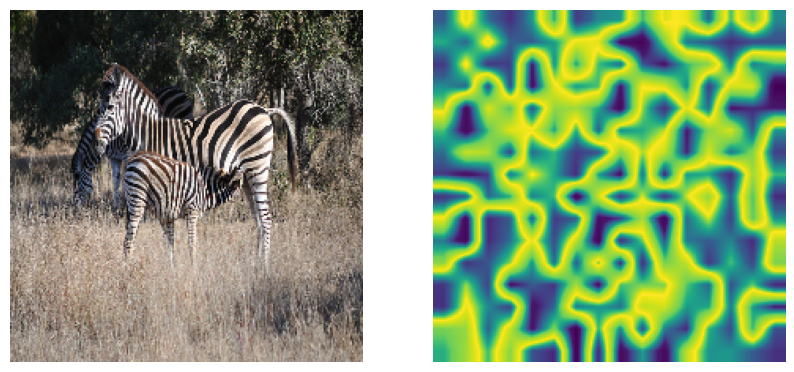

Question: What is sitting in the basket? 
	Answer: dog
	Predicted: 'structure '


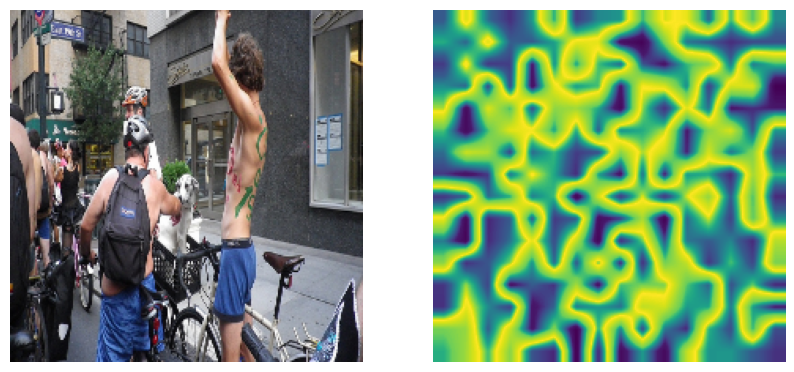

Question: What material is the fence made out of? 
	Answer: wood
	Predicted: 'structure '


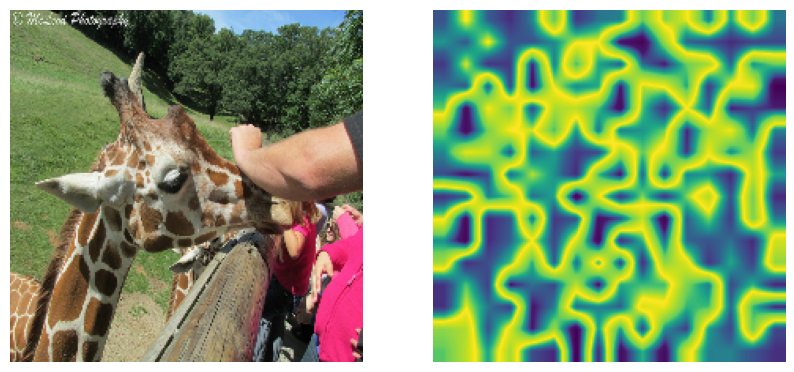

Question: What's on fire? 
	Answer: candles
	Predicted: 'coalition '


Question: Is the umbrella in front of or behind the girl? 
	Answer: behind
	Predicted: 'reflections '


Question: Does this girl have short hair? 
	Answer: no
	Predicted: 'danforth '


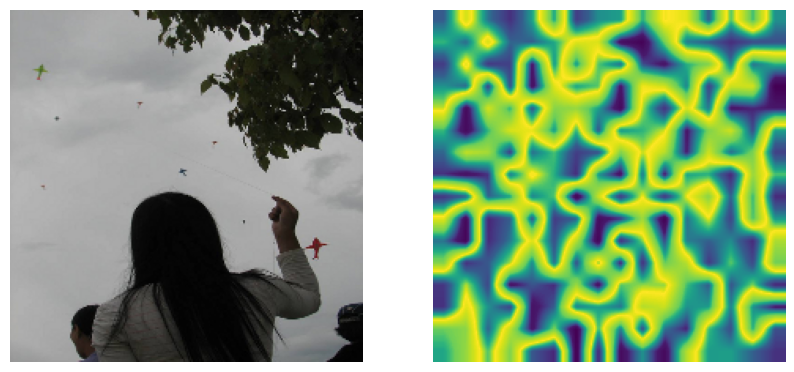

Question: Is the bird curious about the small figure? 
	Answer: yes
	Predicted: 'structure '


Question: What is the napkin made of? 
	Answer: cloth
	Predicted: 'structure '


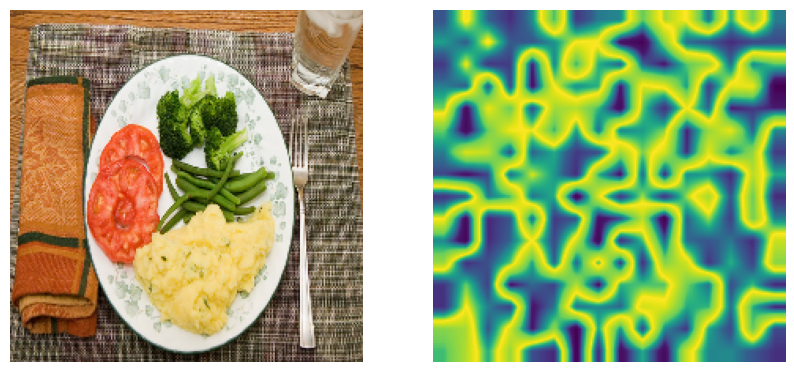

Question: What is the boy riding? 
	Answer: skateboard
	Predicted: 'structure '


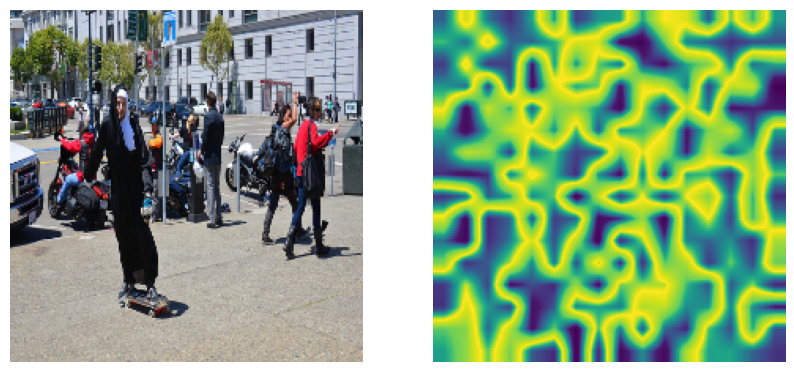

Question: How many light towers do you see? 
	Answer: 3
	Predicted: 'structure '


Question: What design is the cinnamon in on each roll? 
	Answer: swirl
	Predicted: 'skatepark '


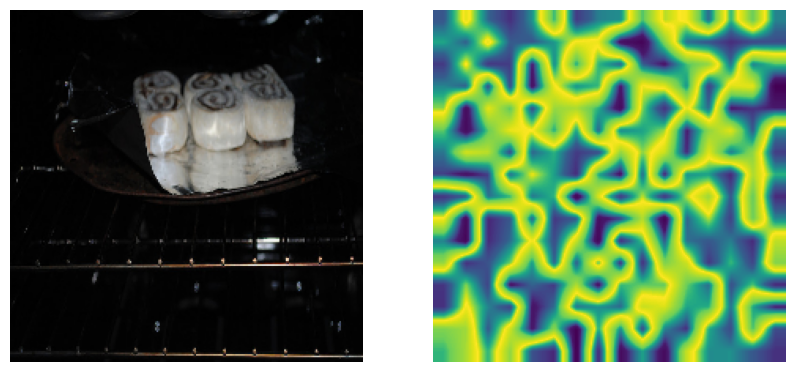

Question: Is there a ski lift? 
	Answer: yes
	Predicted: 'skatepark '


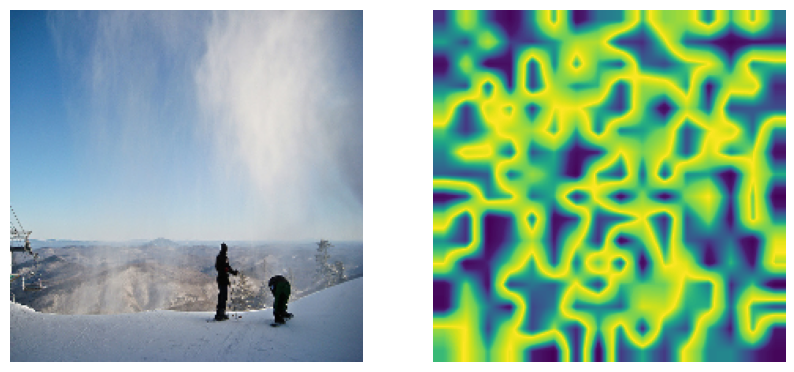

Question: What color is the remote? 
	Answer: white
	Predicted: 'structure '


Question: Why is she walking in the street? 
	Answer: carry
	Predicted: 'structure '


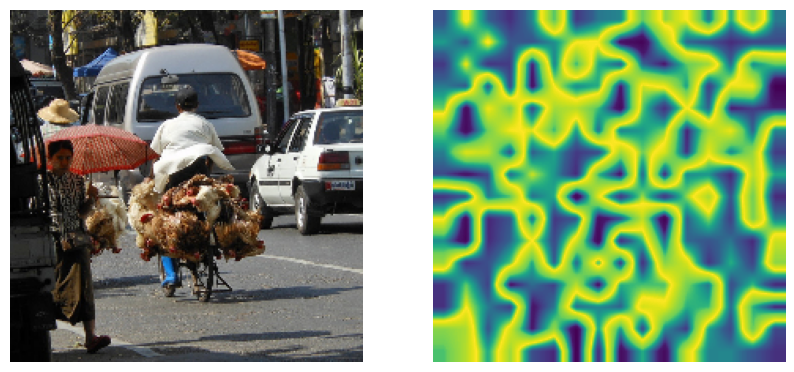

Question: What is on the luggage handle? 
	Answer: tag
	Predicted: 'lasagna '


Question: What color is the hydrant? 
	Answer: red
	Predicted: 'structure '


Question: What does this animal's vocal sound like? 
	Answer: meow
	Predicted: 'handicap '


Question: Is this a fire engine? 
	Answer: yes
	Predicted: 'asda '


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample = test_df.sample(30)
for i in range(30):
    row = sample.iloc[i]
    image = row["image"]
    question = row["question"].split(START_TOKEN)[0]
    answer = row["answer"]
    attention_map = get_attention_map(question, image)
    predicted_answer = predict(question, image)
    print(f"Question: {question}")
    print(f"\tAnswer: {answer}")
    print(f"\tPredicted: '{predicted_answer}'")
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    im = cv2.imread(image)
    im = cv2.resize(im, (224, 224))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax[0].imshow(im)
    ax[1].imshow(attention_map)
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()